This numerical calculation is refered to "Propagation constant-based diameter measurement technique for a submicrometer-scale optical fiber."https://doi.org/10.1364/OL.521545


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv, kv, jvp, kvp
from scipy.optimize import root_scalar

the effective refractive index $n_{eff}$ which is between the refractive index of the air $n_{air}$ and fiber $n_{fiber}$.
$$
n_{air}<n_{eff}<n_{fiber}
$$

$$
\beta = n_{eff}k_{0} = \frac{2\pi n_{eff} }{ \lambda_{0}} .  (1)
$$
Where, $\beta$ is the propagation constant, $k_{0} = \frac{2\pi}{ \lambda_{0}}$ is the angular wave number in air, and $\lambda_{0}$ is the wavelength in vacuum.

In [3]:
# Constants (as arrays)
n_fiber_list = [1.450, 1.447, 1.444]  # Refractive index of the fiber core
wavelength_list = [1.064, 1.310, 1.550]  # Corresponding wavelengths in micrometers (µm)
n_air = 1.0102793207800356  # Refractive index of the cladding (air for a submicron fiber)
pairs = list(zip(n_fiber_list, wavelength_list))

Optical fiber eigenvalue equation : 
$$
m^2 (\frac{1}{u^2} + \frac{1}{w^2})(\frac{1}{u^2} + \frac{n^2_{air}}{n^2_{fiber}}・\frac{1}{w^2})\\
= [\frac{1}{u}・\frac{J'_{m}(u)}{J_{m}(u)} + \frac{1}{w}・\frac{K'_{m}(w)}{K_{m}(w)}][\frac{1}{u}・\frac{J'_{m}(u)}{J_{m}(u)} + \frac{n^2_{air}}{n^2_{fiber}}・\frac{1}{w}・\frac{K'_{m}(w)}{K_{m}(w)}]\\
u = \frac{D}{2}・\sqrt{k^2_{0}n^2_{fiber} - \beta^2} , w = \frac{D}{2}・\sqrt{\beta^2 - k^2_{0}n^2_{air}}.(2)
$$
where, $D$ is the diameter of the fiber, $J_{m}$ is the Bessel function of the first kind, $K_{m}$ is the modified Bessek function of the second kind, $m$ is the Bessel function order.
Currently, the measurement target is single-mode ($HE_{11}$ mode)is considered; thus, $m$ is taken to be $1$.

In [4]:
# Function to calculate beta by solving the eigenvalue equation
def calculate_beta(diameter, n_fiber, wavelength):
    k0 = 2 * np.pi / wavelength  # Wavenumber in vacuum
    
    def eigenvalue_eq(beta):
        if beta > k0 * n_fiber or beta < k0 * n_air:
            return np.inf
        
        u = (diameter / 2) * np.sqrt(k0**2 * n_fiber**2 - beta**2)
        w = (diameter / 2) * np.sqrt(beta**2 - k0**2 * n_air**2)
        
        if u <= 0 or w <= 0:
            return np.inf
        
        lhs = ((1/u**2) + (1/w**2)) * ((1/u**2)+((n_air**2 / n_fiber**2) * (1/w**2)))
        rhs = (((1 / u) * (jvp(1, u) / jv(1, u))) + ((1 / w) * (kvp(1, w) / kv(1, w)))) * \
              (((1 / u) * (jvp(1, u) / jv(1, u))) + ((n_air**2 / n_fiber**2) * (1 / w) * (kvp(1, w) / kv(1, w))))
        return lhs - rhs
    
    beta_min = k0 * n_air + 1e-5
    beta_max = k0 * n_fiber - 1e-5
    
    if eigenvalue_eq(beta_min) * eigenvalue_eq(beta_max) > 0:
        return np.nan
    
    try:
        sol = root_scalar(eigenvalue_eq, bracket=[beta_min, beta_max], method='brentq', xtol=1e-6)
        return sol.root if sol.converged else np.nan
    except ValueError:
        return np.nan


In [5]:
print(calculate_beta(0.5, 1.44, 1.550))
print(2*np.pi/1.550)

4.11608151172764
4.053667940115862


In [6]:
# Diameters for calculation
diameters = np.linspace(0.100, 1.200, 30)  # Diameters in micrometers (µm)

# Store results
results = {}

for n_fiber, wavelength in pairs:
    betas = [calculate_beta(d, n_fiber, wavelength) for d in diameters]
    pitches = [np.pi / beta * 1000 if not np.isnan(beta) else np.nan for beta in betas]
    
    filtered_diameters = [d for d, beta in zip(diameters, betas) if not np.isnan(beta)]
    filtered_betas = [beta for beta in betas if not np.isnan(beta)]
    filtered_pitches = [pitch for pitch in pitches if not np.isnan(pitch)]
    
    results[(n_fiber, wavelength)] = {
        "diameters": filtered_diameters,
        "betas": filtered_betas,
        "pitches": filtered_pitches
    }


[np.float64(0.3275862068965517), np.float64(0.3655172413793103), np.float64(0.4034482758620689), np.float64(0.44137931034482747), np.float64(0.47931034482758617), np.float64(0.5172413793103448), np.float64(0.5551724137931033), np.float64(0.5931034482758619), np.float64(0.6310344827586206), np.float64(0.6689655172413792), np.float64(0.7068965517241378), np.float64(0.7448275862068964), np.float64(0.782758620689655), np.float64(0.8206896551724137), np.float64(0.8586206896551722), np.float64(0.8965517241379308), np.float64(0.9344827586206895), np.float64(0.9724137931034481), np.float64(1.0103448275862068), np.float64(1.0482758620689654), np.float64(1.086206896551724), np.float64(1.1241379310344826), np.float64(1.1620689655172414), np.float64(1.2)]


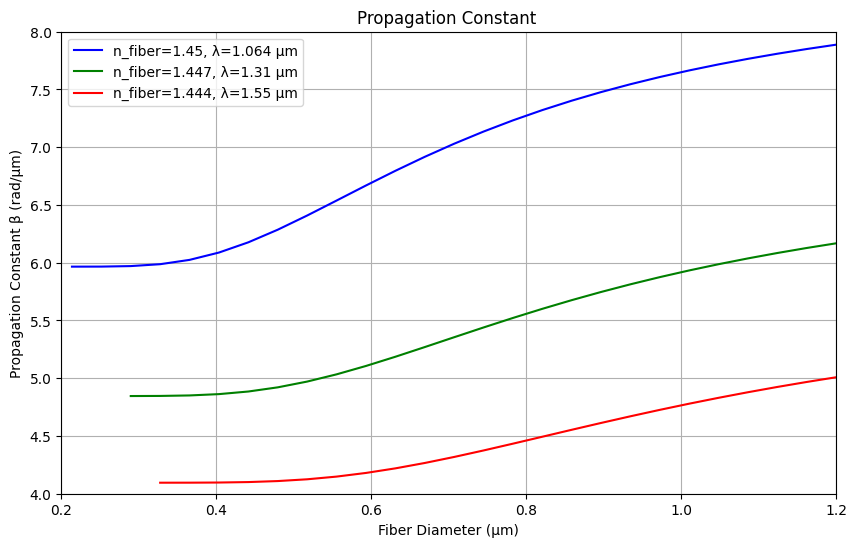

In [7]:
# Plot results
fig, ax1 = plt.subplots(figsize=(10, 6))
#ax2 = ax1.twinx()

colors = ['b', 'g', 'r']

for i, ((n_fiber, wavelength), data) in enumerate(results.items()):
    ax1.plot(data["diameters"], data["betas"], color=colors[i], linestyle='-', label=f"n_fiber={n_fiber}, λ={wavelength} µm")
    #ax2.plot(data["diameters"], data["pitches"], color=colors[i], linestyle='--', marker='x', label=f"Pitch for n_fiber={n_fiber}, λ={wavelength} µm")

ax1.set_xlim(0.2,1.2)
ax1.set_ylim(4,8)
ax1.set_xlabel("Fiber Diameter (µm)")
ax1.set_ylabel("Propagation Constant β (rad/µm)")
print(data["diameters"])
#ax2.set_ylim(800,350)
#ax2.set_ylabel("Standing Wave Pitch (nm)")
ax1.set_title("Propagation Constant ")
ax1.legend(loc='upper left')
#ax2.legend(loc='upper right')
ax1.grid(True)
plt.show()

The index of refraction of optical quality fused silica ($SiO_{2}$) is estimated based on the Sellmeier equation.

In [8]:
#Sellmeir-type dispertions
def refractive_index_fused_silica(lamda):
    return np.sqrt(1 + ((0.6961663 * lamda**2)/((lamda**2)-(0.0684043)**2)) \
                   + ((0.4079426 * lamda**2) / ((lamda**2) - (0.1162414)**2))\
                      + ((0.8974794 * lamda**2)/(lamda**2 - (9.896161)**2)))

In [9]:
refractive_index_fused_silica(1.55021)

np.float64(1.4440211052865322)

From standing-wave pitch, we can estimate the Fiber diameter.

In [15]:
# Function to calculate diameter by solving eigen equation
def calculate_diameter(beta, n_fiber, wavelength):
    k0 = 2 * np.pi / wavelength  # Wavenumber in vacuum
    #beta = np.pi / pitch

    def eigenvalue_eq(diameter):
        if beta > k0 * n_fiber or beta < k0 * n_air:
            return np.inf
        
        u = (diameter / 2) * np.sqrt(k0**2 * n_fiber**2 - beta**2)
        w = (diameter / 2) * np.sqrt(beta**2 - k0**2 * n_air**2)
        
        if u <= 0 or w <= 0:
            return np.inf
        
        lhs = ((1/u**2) + (1/w**2)) * ((1/u**2)+((n_air**2 / n_fiber**2) * (1/w**2)))
        rhs = (((1 / u) * (jvp(1, u) / jv(1, u))) + ((1 / w) * (kvp(1, w) / kv(1, w)))) * \
              (((1 / u) * (jvp(1, u) / jv(1, u))) + ((n_air**2 / n_fiber**2) * (1 / w) * (kvp(1, w) / kv(1, w))))
        return lhs - rhs
    
    diameter_min = 0.005
    diameter_max = 1.30
    
    if eigenvalue_eq(diameter_min) * eigenvalue_eq(diameter_max) > 0:
        return np.nan
    
    try:
        sol = root_scalar(eigenvalue_eq, bracket=[diameter_min, diameter_max], method='brentq', xtol=1e-6)
        return sol.root if sol.converged else np.nan
    except ValueError:
        return np.nan

In [11]:
wl_1 = 1.55 # um
wl_2 = 1.064 # um
pitch_m1 = 0.741 # um
pitch_m2 = 0.461 # um
stddv_pitch = 20e-3 # um

In [20]:
beta = 2 * np.pi * 1.0310 / 1.390
calculate_diameter(beta=beta, n_fiber=1.44, wavelength=1.389) # um, 1, um 

0.5308491351085106

In [36]:
import numpy as np

# パラメータ設定
pitch_m1 = 0.741
pitch_m2 = 0.461
sigma = 20e-3
n_fiber = 1.44
wl_1 = 1.55
wl_2 = 1.064

# 探索範囲設定
delta_gamma_range = np.linspace(-0.1, 0.1, 200)
delta_range = np.linspace(-sigma, sigma, 50)

max_D = -np.inf
best_setting = None

for delta_gamma in delta_gamma_range:
    for delta_1 in delta_range:
        for delta_2 in delta_range:
            pitch1 = pitch_m1 + delta_gamma + delta_1
            pitch2 = pitch_m2 + delta_gamma + delta_2

            D1 = calculate_diameter(pitch=pitch1, n_fiber=n_fiber, wavelength=wl_1)
            D2 = calculate_diameter(pitch=pitch2, n_fiber=n_fiber, wavelength=wl_2)

            if np.isclose(D1, D2, rtol=1e-4):  # D1 ≈ D2 を判定
                if D1 > max_D:
                    max_D = D1
                    best_setting = (delta_gamma, delta_1, delta_2)

print("Max D:", max_D)
print("Best ΔΓ, δ1, δ2:", best_setting)


Max D: 0.9635560875078256
Best ΔΓ, δ1, δ2: (np.float64(-0.052763819095477386), np.float64(-0.02), np.float64(0.008571428571428574))
